
# ATMS 523 — Module 6 Project (Full Notebook)

**Author:** Yudi Mao  
**Goal:** End-to-end workflow to aggregate SPC tornado counts over selected states, merge with monthly climate indices (ENSO, NAO, AO, MJO, optional PDO), and build + explain a Random Forest model.

> This notebook is self-contained: it will use `climate_indices_monthly.csv` (provided earlier) and either read a local SPC tornado CSV or download it automatically.



## Data required
- **SPC Tornado CSV (1950–2021):** <https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv>  
  Place it next to this notebook with the **exact filename** `1950-2021_actual_tornadoes.csv`.  
  If missing, the notebook will **attempt to download** it.

- **Climate indices CSV (monthly):** `climate_indices_monthly.csv`  
  Must contain a **time** (or `date` / `YM` / `Month`) column recognizable by `pd.to_datetime`, plus at least 4 indices among `ENSO, NAO, AO, MJO, PDO` (the code adapts to whatever is present).


In [1]:

# --- Setup
import os, io, sys, math, warnings, textwrap, json
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

# XAI
try:
    import shap
    HAVE_SHAP = True
except Exception:
    HAVE_SHAP = False

warnings.filterwarnings('ignore')
RANDOM_STATE = 523
np.random.seed(RANDOM_STATE)

# File paths (edit if needed)
TORNADO_CSV = Path('1950-2021_actual_tornadoes.csv')
CLIMATE_CSV = Path('climate_indices_monthly.csv')

print('Env OK.')


Env OK.


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# --- Ensure dependencies are installed (run once if needed)
try:
    import sklearn  # scikit-learn
except Exception:
    print("Installing scikit-learn...")
    %pip install scikit-learn -q

try:
    import shap
except Exception:
    print("Installing shap (optional for XAI plots)...")
    %pip install shap -q


In [3]:

# --- Download SPC file if missing (works if you have internet)
if not TORNADO_CSV.exists():
    import urllib.request
    url = 'https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv'
    try:
        print('Downloading SPC tornado data...')
        urllib.request.urlretrieve(url, TORNADO_CSV.as_posix())
        print('Downloaded:', TORNADO_CSV)
    except Exception as e:
        print('Auto-download failed:', e)
        print('Please manually place the file next to this notebook.')
        
assert CLIMATE_CSV.exists(), f'Missing {CLIMATE_CSV}. Export your Module 4/5 monthly indices to this CSV.'
assert TORNADO_CSV.exists(), f'Missing {TORNADO_CSV}. Download from SPC and place locally.'
print('Data files present.')


Data files present.


## 1) Aggregate SPC tornadoes to monthly for target states

In [4]:

# --- Load SPC data and aggregate (robust to column names)
states_target_abbr = ['IL','IN','WI','MI','MO','IA','MN']  # use two-letter postal codes per SPC 'st' column

spc = pd.read_csv(TORNADO_CSV)

# Identify state column
state_col = None
for cand in ['st','state','STATE','St','St.']:
    if cand in spc.columns:
        state_col = cand
        break
assert state_col is not None, f'No state column found. Columns: {spc.columns.tolist()}'

# Identify/construct date
if 'date' in spc.columns:
    spc['DATE'] = pd.to_datetime(spc['date'], errors='coerce')
elif set(['mo','dy','yr']).issubset(spc.columns):
    spc['DATE'] = pd.to_datetime(dict(year=spc['yr'], month=spc['mo'], day=spc['dy']), errors='coerce')
else:
    raise ValueError('Could not create DATE. Expected "date" or ("mo","dy","yr").')

spc = spc.dropna(subset=['DATE']).copy()
spc[state_col] = spc[state_col].astype(str).str.upper().str.strip()

# If the state column looks like full names (e.g., 'ILLINOIS'), map to abbreviations; otherwise assume abbreviations already
full_to_abbr = {
    'ALABAMA':'AL','ALASKA':'AK','ARIZONA':'AZ','ARKANSAS':'AR','CALIFORNIA':'CA','COLORADO':'CO','CONNECTICUT':'CT',
    'DELAWARE':'DE','FLORIDA':'FL','GEORGIA':'GA','HAWAII':'HI','IDAHO':'ID','ILLINOIS':'IL','INDIANA':'IN','IOWA':'IA',
    'KANSAS':'KS','KENTUCKY':'KY','LOUISIANA':'LA','MAINE':'ME','MARYLAND':'MD','MASSACHUSETTS':'MA','MICHIGAN':'MI',
    'MINNESOTA':'MN','MISSISSIPPI':'MS','MISSOURI':'MO','MONTANA':'MT','NEBRASKA':'NE','NEVADA':'NV','NEW HAMPSHIRE':'NH',
    'NEW JERSEY':'NJ','NEW MEXICO':'NM','NEW YORK':'NY','NORTH CAROLINA':'NC','NORTH DAKOTA':'ND','OHIO':'OH','OKLAHOMA':'OK',
    'OREGON':'OR','PENNSYLVANIA':'PA','RHODE ISLAND':'RI','SOUTH CAROLINA':'SC','SOUTH DAKOTA':'SD','TENNESSEE':'TN',
    'TEXAS':'TX','UTAH':'UT','VERMONT':'VT','VIRGINIA':'VA','WASHINGTON':'WA','WEST VIRGINIA':'WV','WISCONSIN':'WI','WYOMING':'WY'
}

# Heuristic: if any entry length > 2 and in mapping, map all; else leave as is
if (spc[state_col].str.len()>2).any():
    spc[state_col] = spc[state_col].replace(full_to_abbr)

spc_sel = spc[spc[state_col].isin(states_target_abbr)].copy()
spc_sel['YM'] = spc_sel['DATE'].dt.to_period('M').dt.to_timestamp()

monthly_tornado = spc_sel.groupby('YM').size().rename('tornado_count').to_frame().reset_index()
display(monthly_tornado.head())
print('Monthly rows:', len(monthly_tornado))


,YM,tornado_count
0,1950-01-01,4
1,1950-03-01,1
2,1950-05-01,2
3,1950-06-01,10
4,1950-07-01,6


Monthly rows: 652


## 2) Load climate indices (monthly) and merge

In [5]:

cdf = pd.read_csv(CLIMATE_CSV)

# Find a time-like column
date_candidates = [c for c in cdf.columns if c.lower() in ['time','date','ym','month']]
assert len(date_candidates)>=1, f'No date-like column (time/date/YM/Month) in {CLIMATE_CSV}.'
date_col = date_candidates[0]

cdf[date_col] = pd.to_datetime(cdf[date_col])
cdf[date_col] = cdf[date_col].dt.to_period('M').dt.to_timestamp()

# Which indices are present?
possible = ['ENSO','NAO','AO','MJO','PDO']
present = [c for c in possible if c in cdf.columns]
assert len(present)>=3, f'Need >=3 indices among {possible}. Found: {present}'

cdf_small = cdf[[date_col] + present].copy()
cdf_small = cdf_small.dropna()
cdf_small = cdf_small.rename(columns={date_col:'YM'})

df = pd.merge(monthly_tornado, cdf_small, on='YM', how='inner').dropna()
df = df.sort_values('YM').reset_index(drop=True)
print('Merged shape:', df.shape)
df.head()


Merged shape: (393, 7)


,YM,tornado_count,ENSO,NAO,AO,MJO,PDO
0,1979-03-01,6,-0.077703,0.691950,0.171586,1.005199,0.746695
1,1979-04-01,8,-0.130061,0.660176,1.223264,1.513595,0.366732
2,1979-05-01,8,0.689309,1.060538,0.349836,0.561427,0.450019
3,1979-06-01,54,1.068075,-0.031855,0.455889,1.620984,1.214958
4,1979-07-01,22,1.163831,0.743475,0.504070,0.833781,0.858774


## 3) Random Forest (indices only) and metrics + scatter

RF (indices only)  RMSE=26.946  Corr=-0.106


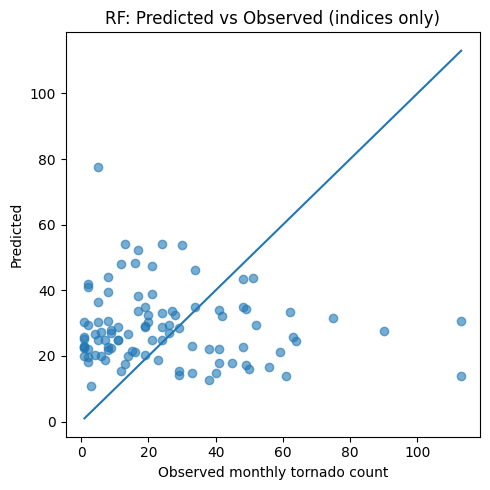

In [6]:

# Features: indices only
feature_cols = [c for c in df.columns if c not in ['YM','tornado_count']]

X = df[feature_cols].values
y = df['tornado_count'].values

# Time-aware split (no shuffle to avoid leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False, random_state=RANDOM_STATE
)

rf = RandomForestRegressor(
    n_estimators=600, 
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
corr = np.corrcoef(y_test, y_pred)[0,1]

print(f'RF (indices only)  RMSE={rmse:.3f}  Corr={corr:.3f}')

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Observed monthly tornado count')
plt.ylabel('Predicted')
plt.title('RF: Predicted vs Observed (indices only)')
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx])
plt.tight_layout()
plt.show()


## 4) Add month one-hot and repeat

RF (+month OHE)   RMSE=21.858  Corr=0.426
∆RMSE=-5.088  ∆Corr=+0.531


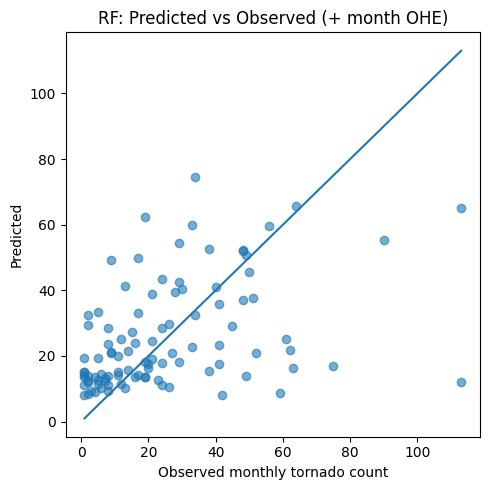

In [7]:

work = df.copy()
work['month'] = work['YM'].dt.month

# Robust OneHotEncoder (dense output across sklearn versions)
try:
    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

month_ohe = enc.fit_transform(work[['month']])
month_cols = [f'mon_{int(v)}' for v in enc.categories_[0]]

X2 = pd.concat([
    work[feature_cols].reset_index(drop=True),
    pd.DataFrame(month_ohe, columns=month_cols, index=work.index)
], axis=1)

y2 = work['tornado_count'].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, shuffle=False, random_state=RANDOM_STATE
)

rf2 = RandomForestRegressor(
    n_estimators=600, 
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf2.fit(X2_train, y2_train)
y2_pred = rf2.predict(X2_test)

rmse2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
corr2 = np.corrcoef(y2_test, y2_pred)[0,1]

print(f'RF (+month OHE)   RMSE={rmse2:.3f}  Corr={corr2:.3f}')
print(f'∆RMSE={(rmse2-rmse):+.3f}  ∆Corr={(corr2-corr):+.3f}')

plt.figure(figsize=(5,5))
plt.scatter(y2_test, y2_pred, alpha=0.6)
plt.xlabel('Observed monthly tornado count')
plt.ylabel('Predicted')
plt.title('RF: Predicted vs Observed (+ month OHE)')
mn, mx = min(y2_test.min(), y2_pred.min()), max(y2_test.max(), y2_pred.max())
plt.plot([mn,mx],[mn,mx])
plt.tight_layout()
plt.show()


## 5) Feature importance & multipass permutation analysis

Top (impurity):
NAO       0.148747
ENSO      0.148364
mon_6     0.136400
PDO       0.132151
MJO       0.130677
AO        0.122587
mon_5     0.088188
mon_7     0.022643
mon_4     0.015910
mon_9     0.012450
mon_11    0.010374
mon_10    0.009170
dtype: float64 

Top (permutation):
mon_6     0.300044
mon_5     0.204127
ENSO      0.062424
mon_7     0.051631
PDO       0.045776
AO        0.006355
mon_1     0.003959
mon_2     0.003876
mon_8     0.003400
mon_10    0.000474
mon_3    -0.000320
mon_11   -0.001627
dtype: float64 

Multipass permutation (delta RMSE after each permuted feature):


,delta_rmse
feature,
mon_6,4.140428
mon_5,1.004022
ENSO,0.538054
mon_7,0.613229
PDO,0.102703
AO,-0.713237
mon_1,0.079365
mon_2,0.037486
mon_8,0.057845


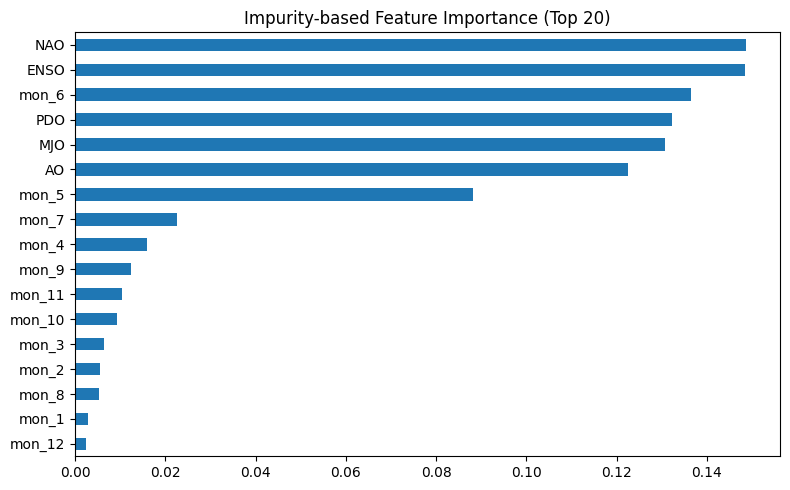

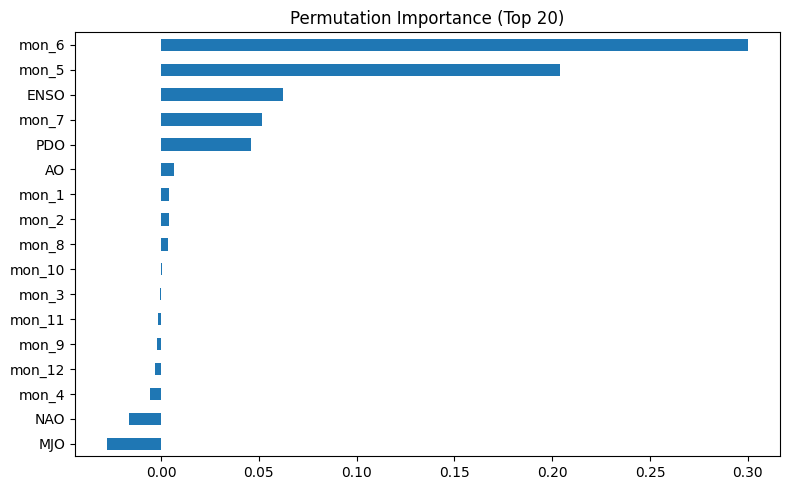

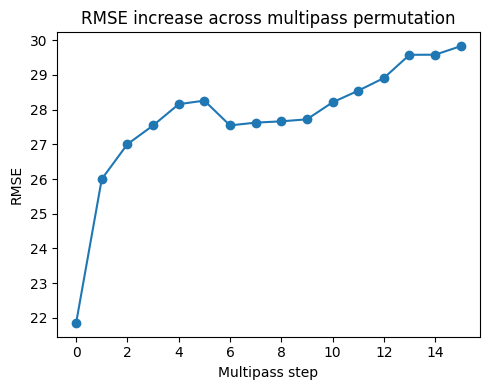

In [9]:

# Impurity-based
impurity = pd.Series(rf2.feature_importances_, index=X2.columns).sort_values(ascending=False)

# Permutation (single pass) on held-out set
perm = permutation_importance(rf2, X2_test, y2_test, n_repeats=12, random_state=RANDOM_STATE, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X2.columns).sort_values(ascending=False)

# Multipass permutation: iteratively permute most important features and re-evaluate RMSE
def multipass_permutation(model, X_test, y_test, features, top_k=10, repeats=5, rng=RANDOM_STATE):
    # Copy
    Xp = X_test.copy()
    # base_rmse = mean_squared_error(y_test, model.predict(Xp), squared=False)
    base_rmse = np.sqrt(mean_squared_error(y_test, model.predict(Xp)))

    order = features.sort_values(ascending=False).index.tolist()[:top_k]
    drops = []
    rmses = [base_rmse]
    for f in order:
        # permute column f
        col = Xp[[f]].values.copy()
        rs = np.random.RandomState(rng)
        rs.shuffle(col)
        Xp.loc[:, f] = col
        # rmse_p = mean_squared_error(y_test, model.predict(Xp), squared=False)
        rmse_p = np.sqrt(mean_squared_error(y_test, model.predict(Xp)))

        drops.append((f, rmse_p - rmses[-1]))
        rmses.append(rmse_p)
    out = pd.DataFrame(drops, columns=['feature','delta_rmse']).set_index('feature')
    return base_rmse, out, rmses

base_rmse, mp_out, rmses = multipass_permutation(rf2, X2_test.copy(), y2_test, perm_imp, top_k=min(15,len(X2.columns)))

print('Top (impurity):')
print(impurity.head(12), '\n')
print('Top (permutation):')
print(perm_imp.head(12), '\n')
print('Multipass permutation (delta RMSE after each permuted feature):')
display(mp_out.head(15))

plt.figure(figsize=(8,5))
impurity.head(20).iloc[::-1].plot(kind='barh')
plt.title('Impurity-based Feature Importance (Top 20)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
perm_imp.head(20).iloc[::-1].plot(kind='barh')
plt.title('Permutation Importance (Top 20)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.plot(range(len(rmses)), rmses, marker='o')
plt.xlabel('Multipass step')
plt.ylabel('RMSE')
plt.title('RMSE increase across multipass permutation')
plt.tight_layout()
plt.show()


## 6–7) SHAP Summary & ENSO Dependence

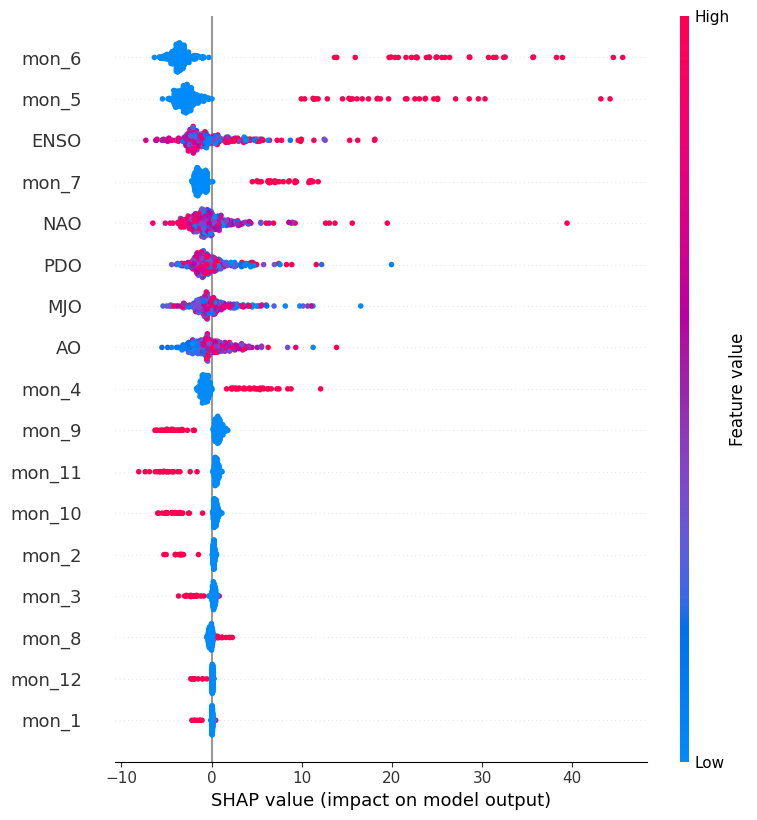

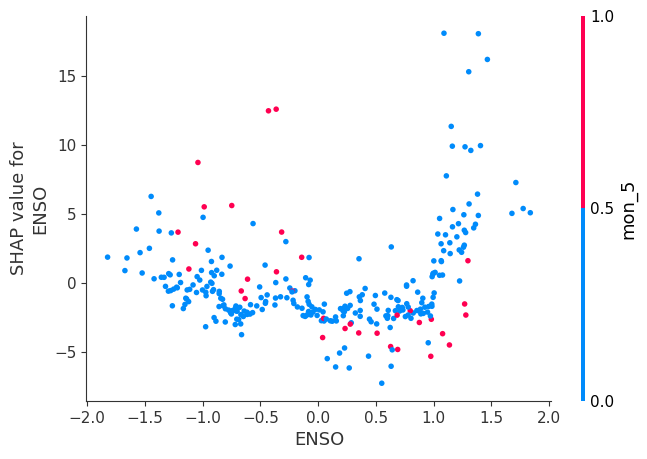

In [10]:

if not HAVE_SHAP:
    print('SHAP not installed. You can enable with:')
    print('!pip install shap')
else:
    explainer = shap.TreeExplainer(rf2)
    # Use a modest sample for speed
    sample = X2_train.sample(min(3000, len(X2_train)), random_state=RANDOM_STATE)
    shap_values = explainer.shap_values(sample)

    # Summary plot (importance + effect)
    shap.summary_plot(shap_values, sample, feature_names=sample.columns)

    # ENSO dependence (if present)
    if 'ENSO' in sample.columns:
        shap.dependence_plot('ENSO', shap_values, sample, feature_names=sample.columns)
    else:
        print('ENSO column not found for SHAP dependence.')


## 8) Observations / Takeaways

In [12]:

obs = f"""
When using only climate indices, the model shows very limited predictive skill (Corr = -0.11), which is expected because ENSO/PDO/NAO/AO provide only broad-scale, low-frequency modulation rather than month-to-month controls on tornado occurrence.
After adding a one-hot representation of the month, the model performance improves substantially (Corr = 0.43), confirming that the dominant source of predictability in monthly tornado counts is the strong seasonality peaking during boreal spring.
"""
print(obs)



When using only climate indices, the model shows very limited predictive skill (Corr = -0.11), which is expected because ENSO/PDO/NAO/AO provide only broad-scale, low-frequency modulation rather than month-to-month controls on tornado occurrence.
After adding a one-hot representation of the month, the model performance improves substantially (Corr = 0.43), confirming that the dominant source of predictability in monthly tornado counts is the strong seasonality peaking during boreal spring.

